In [2]:
# IMPORT ESSENTIAL MODULES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as st
from scipy.stats import bernoulli, lognorm, poisson, gamma, nbinom
from numba import jit

In [5]:
# IMPORT DATA
hh_df = pd.read_csv('Zambia_Ebola.csv', index_col=None, header=None)  
new_header = hh_df.iloc[0] #grab the first row for the header
hh_df = hh_df[1:] #take the data less the header row
hh_df.columns = new_header #set the header row as the df header
hh_df.head()

,hh_id,hh_age_1,hh_age_2,hh_age_3,hh_age_4,hh_age_5,hh_age_6,hh_age_7,hh_age_8,hh_age_9,...,hh_ego_9,hh_ego_10,hh_ego_11,hh_ego_12,hh_ego_13,hh_ego_14,hh_ego_15,hh_ego_16,hh_ego_17,hh_ego_18
1,HH30001,62,12,12,39,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HH30004,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HH30008,42,15,17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HH30012,36,6,3,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,HH30024,21,19,16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
dfs = {}

for i in range(18):
    subset_df = hh_df.filter(regex='_{}$'.format(i + 1)).copy()
    subset_df.columns = subset_df.columns.str.rstrip("_{}".format(i + 1))
    dfs[i + 1] = subset_df

In [4]:
# CONTACT MATRIX
non_hh_contact_matrix = {('adults', 'children'): 1.2, ('adults','adolescents'): 1.5, ('adults', 'adults'): 5.3, 
     ('adolescents', 'children'): 2.0, ('adolescents', 'adolescents'): 3.6, 
     ('adolescents', 'adults'): np.nan, ('children', 'children'): 0.2, 
     ('children', 'adolescents'): np.nan, ('children', 'adults'): np.nan}

# contact matrix but in numeral keys
non_hh_contact_matrix_mean = {(2, 0): 1.2, (2,1): 1.5, (2, 2): 5.3, 
     (1,0): 2.0, (1, 1): 3.6,  (1, 2): 1.5, (0, 0): 0.2, 
     (0, 1): 2.0, (0, 2): 1.2}

non_hh_contact_df = pd.DataFrame(non_hh_contact_matrix.items(), columns=['pair', 'value'])
non_hh_contact_df

,pair,value
0,"(adults, children)",1.2
1,"(adults, adolescents)",1.5
2,"(adults, adults)",5.3
3,"(adolescents, children)",2.0
4,"(adolescents, adolescents)",3.6
5,"(adolescents, adults)",NaN
6,"(children, children)",0.2
7,"(children, adolescents)",NaN
8,"(children, adults)",NaN


In [7]:
non_hh_contact_matrix_sd = {('adults', 'children'): 0.1, ('adults','adolescents'): 0.0, ('adults', 'adults'): 0.3, 
     ('adolescents', 'children'): 0.1, ('adolescents', 'adolescents'): 0.2, 
     ('adolescents', 'adults'): np.nan, ('children', 'children'): 0.1, 
     ('children', 'adolescents'): np.nan, ('children', 'adults'): np.nan}

In [10]:
dfs = []

for i in range(18):
    subset_df = hh_df.filter(regex='_{}$'.format(i + 1)).copy()
    subset_df.columns = subset_df.columns.str.rstrip("_{}".format(i + 1))
    subset_df['hh_id'] = hh_df['hh_id']
    dfs.append(subset_df)

matrix_df = pd.concat(dfs)
matrix_df.dropna(inplace=True)
matrix_df
#matrix_df[matrix_df['hh_id'] == 'HH30001']

,hh_age,hh_gender,hh_ego,hh_id
1,62,F,1,HH30001
2,25,M,8,HH30004
3,42,M,1,HH30008
4,36,M,1,HH30012
5,21,M,3,HH30024
...,...,...,...,...
898,5,M,7,HH90095
473,99,M,3,HH60096
898,2,M,7,HH90095
473,99,M,3,HH60096


In [11]:
print(matrix_df.iloc[0]['hh_age'])
print(type(matrix_df.iloc[0]['hh_age']))
matrix_df[matrix_df['hh_id'] == 'HH30008']

62
<class 'str'>


,hh_age,hh_gender,hh_ego,hh_id
3,42,M,1,HH30008
3,15,F,3,HH30008
3,17,F,7,HH30008


In [12]:
age_bin = pd.concat(dfs)
res = []
mean = (0.4326 * 12) + (0.55 * 40) + (0.0174 * 65) 
std = math.sqrt((0.4326 * (12 - mean)**2) + (0.55 * (40 - mean)**2) + (0.0174 * (65 - mean)**2))
for i in range(len(age_bin)):
    
    instance = age_bin.iloc[i]['hh_age']
    # if nan
    #print(instance, type(instance), int(instance))
    if (math.isnan(float(instance)) == False):
        age = int(instance)

        if age < 15:
            age = 0
        elif age <= 65:
            age = 1
        else:
            age = 2
    """else:
        sample = norm.rvs(loc=mean, scale=std)
        if sample < 15:
            age = 0
        elif sample <= 65:
            age = 1
        else:
            age = 2"""

    res.append(age)
age_bin['age'] = res
age_bin = age_bin.dropna().reset_index(drop = True)
age_bin

,hh_age,hh_gender,hh_ego,hh_id,age
0,62,F,1,HH30001,1
1,25,M,8,HH30004,1
2,42,M,1,HH30008,1
3,36,M,1,HH30012,1
4,21,M,3,HH30024,1
...,...,...,...,...,...
14647,5,M,7,HH90095,0
14648,99,M,3,HH60096,2
14649,2,M,7,HH90095,0
14650,99,M,3,HH60096,2


0        62
1        25
2        42
3        36
4        21
         ..
14647     5
14648    99
14649     2
14650    99
14651     2
Name: hh_age, Length: 14652, dtype: object

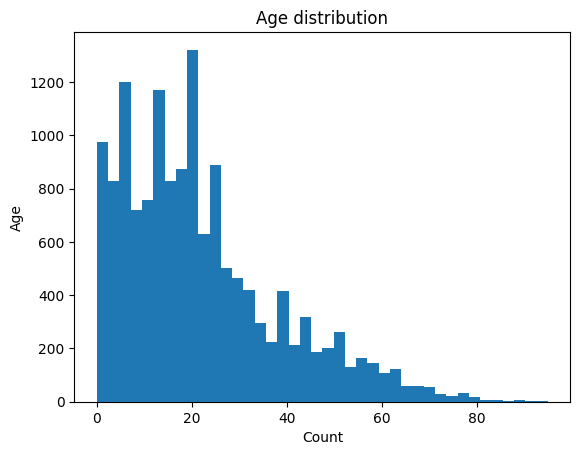

95


In [13]:
data_age = list(age_bin['hh_age'])
display(age_bin['hh_age'])
temp = []

for i in range(len(data_age)):
    data_age[i] = int(data_age[i])
    if data_age[i] < 98:
        temp.append(data_age[i])

#print(data_age[i])
mu = np.mean(temp)
for i in range(len(data_age)):
    if data_age[i] >= 98:
        data_age[i] = poisson.rvs(mu, loc=0, size=1, random_state=None)[0]
plt.hist(data_age, bins = 40)
plt.title('Age distribution')
plt.xlabel('Count')
plt.ylabel('Age')
plt.show()
print(max(data_age))

In [17]:
hh_contacts = {}
hh_id = list(age_bin['hh_id'].unique())
for hh in hh_id:
    #print(hh)
    hh_contacts[hh] = age_bin.loc[age_bin['hh_id'] == hh].index
    

indexes = age_bin.loc[age_bin['hh_id'] == 'HH30028'].index
indexes
#for i in range(len(age_bin)):
#age_bin.loc[age_bin['hh_id'] == 'HH30001']

Index([6, 3437, 6550, 9120], dtype='int64')

In [18]:
#possible_connections_array = np.zeros((len(age_bin), len(age_bin)))
# include all age groups, dict of dict
possible_non_hh_connections_dict = {}
hh_connections_dict = {}

age_dict = age_bin.to_dict()['age']
hh_dict = age_bin.to_dict()['hh_id']

for i in range(len(age_dict)):
    possible_non_hh_connections_dict[i] = {0: [], 1: [], 2: []}
    hh_connections_dict[i] = []
    for j in range(len(age_dict)):
        if i == j:
            continue
        else:
            if hh_dict[i] != hh_dict[j]:
                # age of contact
                age = age_dict[j]
                possible_non_hh_connections_dict[i][age].append(j)
            else:
                hh_connections_dict[i].append(j)
    
    possible_non_hh_connections_dict[i][0] = np.array(possible_non_hh_connections_dict[i][0])
    possible_non_hh_connections_dict[i][1] = np.array(possible_non_hh_connections_dict[i][1])
    possible_non_hh_connections_dict[i][2] = np.array(possible_non_hh_connections_dict[i][2])


# Testy

In [19]:
#possible_connections_array = np.zeros((len(age_bin), len(age_bin)))
# include all age groups, dict of dict
possible_non_hh_connections_array = np.ndarray((len(age_bin), 3, len(age_bin)))
hh_connections_array = np.ndarray((len(age_bin), len(age_bin)))

age_dict = age_bin.to_dict()['age']
hh_dict = age_bin.to_dict()['hh_id']

for i in range(len(age_dict)):
    for j in range(len(age_dict)):
        if i == j:
            continue
        else:
            if hh_dict[i] != hh_dict[j]:
                # age of contact
                age = age_dict[j]
                possible_non_hh_connections_array[i][age][j] = 1
            else:
                hh_connections_array[i][j] = 1

MemoryError: Unable to allocate 1.60 GiB for an array with shape (14652, 14652) and data type float64

In [14]:
# np.where(arr == 1)[0]

@jit(nopython = True)
def temp_sample(N, non_hh_array, hh_array, ages):
    for i in range(N):
        age = ages[i]

        
        size_0 = np.random.poisson(2)#contact_matrix[(age, 0)])
        size_1 = np.random.poisson(3)#contact_matrix[(age, 1)])
        size_2 = np.random.poisson(4)#contact_matrix[(age, 2)])


        temp_0 = np.where(non_hh_array[i][0] == 1)[0]
        temp_1 = np.where(non_hh_array[i][1] == 1)[0]
        temp_2 = np.where(non_hh_array[i][2] == 1)[0]
        
        group_0 = np.random.choice(temp_0, size = size_0, replace = False)
        group_1 = np.random.choice(temp_1, size = size_1, replace = False)
        group_2 = np.random.choice(temp_2, size = size_2, replace = False)

        temp_non_hh = np.concatenate((group_0, group_1, group_2), axis = 0)
        temp_hh = np.where(hh_array[i] == 1)
        

        #connections = np.concatenate((temp_non_hh, temp_hh), axis = 0)



In [252]:
%timeit temp_sample
temp_sample(len(age_bin), possible_non_hh_connections_array, hh_connections_array, np.array(list(age_dict.values())))

11.3 ns ± 0.0452 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [13]:
def sample_connections():
    sample_connections = {}
    for i in range(len(age_bin)):
        age = age_dict[i]
        
        size_0 = poisson.rvs(mu = non_hh_contact_matrix_mean[(age, 0)])
        group_0 = np.random.choice(possible_non_hh_connections_dict[i][0], size = size_0, replace = False)
        
        size_1 = poisson.rvs(mu = non_hh_contact_matrix_mean[(age, 1)])
        group_1 = np.random.choice(possible_non_hh_connections_dict[i][1], size = size_1, replace = False)
        
        size_2 = poisson.rvs(mu = non_hh_contact_matrix_mean[(age, 2)])
        group_2 = np.random.choice(possible_non_hh_connections_dict[i][2], size = size_2, replace = False)
        

        temp_non_hh = np.concatenate((group_0, group_1, group_2), axis = 0)

        temp_hh = np.array(hh_connections_dict[i])
        sample_connections[i] = np.concatenate((temp_non_hh, temp_hh), axis = 0).astype(int)
        
    return sample_connections

In [12]:
ages = np.array(age_bin['age'])
age_cfr = []
gender_cfr = np.array(age_bin['hh_gender'])

for i in range(len(ages)):
    if ages[i] == 0:
        age_cfr.append(0.778)
        #print(age_cfr[i])
    elif ages[i] == 1:
        age_cfr.append(0.8587)
    else:
        age_cfr.append(0.957)
    
    if gender_cfr[i] == 'F':
        gender_cfr[i] = 0.788
    else:
        gender_cfr[i] = 0.828
#gender_cfr

# Sample edge type

In [15]:
"""
handle fluid: 120, 9.7
direct wet contact: 297, 8.3
direct dry contact: 125, 5.6
indirect wet contact: 19, 4.9
indirect dry contact: 74, 1.3
minimal contact: 102, 1
"""
# [276, 119, 112, 96, 70, 19] -> [24.1, 16.7, 30.5, 1, 2.3, 17.2]
#                     
numerator = np.array([120, 297, 125, 19, 74, 102])
denominator = np.array([120, 297, 125, 19, 74, 102])
exposure_multiplier = np.array([9.7, 8.3, 5.6, 4.9, 1.3, 1])

fraction = numerator / np.sum(denominator)

# handle fluid, direct wet, 
nonHH_numerator = np.array([120 - 50, 297 - 200, 125, 19 + 15, 74 + 35, 102 + 200])
nonHH_denominator = np.array([120 - 70, 297 - 240, 125 + 10, 19 + 75, 74 + 185, 102 + 160])
nonHH_fraction = nonHH_denominator / np.sum(nonHH_denominator)
#print(np.random.uniform())
print(fraction, nonHH_fraction)

hh_sar = 0.123
non_hh_sar = 0.048
hh_multiplier = hh_sar / non_hh_sar
pr_base = hh_sar / (np.sum(fraction * exposure_multiplier))

print(pr_base)
print(hh_sar / (np.prod(fraction * exposure_multiplier)))


        
    
    

def sample_edge_weights(all_edges):
    
    exposure = np.zeros((len(all_edges), len(all_edges)))
    for i in range(len(all_edges)):
        for j in (all_edges[i]):
            #temp_pr = np.random.uniform()
            #print(temp_pr, weight_assignment(temp_pr))
            if j in hh_connections_dict[i]:
                exposure[i][j] = np.random.choice(exposure_multiplier, p=fraction)
            else:
                exposure[i][j] = non_hh_sar / pr_base

    return exposure

print(non_hh_sar / pr_base)
#display(pr_base * np.sum(fraction * exposure_multiplier))
#display(pr_base * np.sum(result.x * exposure_multiplier))

[0.16282225 0.40298507 0.16960651 0.02578019 0.10040706 0.13839891] [0.05834306 0.06651109 0.15752625 0.10968495 0.30221704 0.30571762]
0.019619729893515715
10.74235627361954
2.4465168613694277


In [471]:
# np.where(arr == 1)[0]

@jit(nopython = True)
def temp_sample_conditional(N, non_hh_array, hh_array, ages, statuses, flag):
    res = np.array(N)
    for i in range(N):
        if statuses[i] == 5:
            res[i] = np.array([])
        else:
            age = ages[i]

            
            size_0 = np.random.poisson(2)#contact_matrix[(age, 0)])
            size_1 = np.random.poisson(3)#contact_matrix[(age, 1)])
            size_2 = np.random.poisson(4)#contact_matrix[(age, 2)])


            temp_0 = np.where(non_hh_array[i][0] == 1)[0]
            temp_1 = np.where(non_hh_array[i][1] == 1)[0]
            temp_2 = np.where(non_hh_array[i][2] == 1)[0]
            
            group_0 = np.random.choice(temp_0, size = size_0, replace = False)
            group_1 = np.random.choice(temp_1, size = size_1, replace = False)
            group_2 = np.random.choice(temp_2, size = size_2, replace = False)

            temp_non_hh = np.concatenate((group_0, group_1, group_2), axis = 0)
            temp_hh = np.where(hh_array[i] == 1)
            

            connections = np.concatenate((temp_non_hh, temp_hh), axis = 0)
        
    return 



True

# Unlimited Ring vaccination

In [18]:
# no trace, waiting time from onset to report

def full_ring_model(T, prob_infected = pr_base, vax_waiting_time = 9, display = False):
    N = len(age_bin)
    infected_agents = np.random.choice(age_bin['age'].index, size = 10, replace=False)
    agent_status = np.zeros(N)
    agent_incubation = np.zeros(N)
    agent_infection_period = np.zeros(N)
    agent_vaccine_waiting_time = np.zeros(N)
    #agent_missed_status = np.zeros(N)
    #agent_time = np.zeros(N)
    #R_w = 0.66
    #R_m = 7
    #R_v = 0.44
    #prob_missed = 0.2
    """
    status:
    0: susceptible
    1: incubated
    2: infected
    3: vaccinated - waiting time
    4: immune (death/recovvered)
    5: dead
    6: highly infectious
    7: is traced
    """
    for index_case in infected_agents:
        agent_status[index_case] = 2
        # sample infected period, start infection right away
        agent_infection_period[index_case] = int(lognorm.rvs(scale = np.exp(2.2915072), s = 0.1331699))

    infected = np.array([len(infected_agents)])
    susceptible = np.array([N - infected[0]])
    removed = np.array([0])
    deceased = np.array([0])
    vaccinated = np.array([0])
    vaccine_administered = np.array([0])
    vaccines = 0
    incubated = np.array([0])
    for t in range(T):
        
        edge_dict_by_node = sample_connections_conditional(agent_status)
        weight_matrix = sample_edge_weights(edge_dict_by_node)
        
        infected_cases = np.where((agent_status == 2) | (agent_status == 6))[0]
        for i in infected_cases:
            contacts = edge_dict_by_node[i]
            contacts_of_contact = []
            for j in contacts:
                contacts_of_j = edge_dict_by_node[j]
                for k in contacts_of_j:
                    contacts_of_contact.append(k)

            ring = np.unique(np.concatenate((contacts, contacts_of_contact))).astype(int)
            #tracing_waiting_time = gamma.rvs(a=7.5, scale=10.4)
            #sub_ring = np.random.choice(ring, size = int(0.7 * len(ring)), replace = False)
            #print(len(sub_ring))

            for contact in ring: # checking for contacts of index cases
                """
                if contact is infected (2) or already vaccinated (3) or immune/remove (4,5) or was traced (7) 
                => pass
                if there is no vaccine left => pass
                """
                
                if ((agent_status[contact] == 2) or (agent_status[contact] == 5) or (agent_status[contact] == 3) or (agent_status[contact] == 4)):
                    continue
                # if contact is susceptible / incubating -> vax
                elif ((agent_status[contact] == 0) or (agent_status[contact] == 1)):
                    if (bernoulli.rvs(0.7) == 1):
                        agent_vaccine_waiting_time[contact] = vax_waiting_time
                        agent_status[contact] = 3
                        vaccines += 1
        


        for i in range(len(agent_status)):

            if ((agent_status[i] == 2) and 
                (agent_infection_period[i] > 0)): # if agent is inf and during inf period
                
                contacts = edge_dict_by_node[i]
                contacts_of_contact = {}
                for j in contacts:
                    contacts_of_j = edge_dict_by_node[j]
                    contacts_of_contact[j] = []
                    for k in contacts_of_j:
                        contacts_of_contact[j].append(k)
                
                #ring = np.unique(np.concatenate((contacts, contacts_of_contact)))
                ################################
                #temp_infect_prob = prob_infected
                
                for contact in contacts:
                    temp_prob = prob_infected * weight_matrix[i][contact]
                    if agent_status[contact] == 0: # infecting susceptible
                        if temp_prob > 1:
                            temp_prob = 1
                        if (bernoulli.rvs(temp_prob) == 1): # if contact is infected, start incubation
                            agent_status[contact] = 1
                            agent_incubation[contact] = int(lognorm.rvs(scale = np.exp(2.446), s = 0.2841191))
                        
                    for sub_contact in contacts_of_contact[contact]:
                        # infecting susceptible
                        if agent_status[sub_contact] == 0:
                            sub_prob = prob_infected
                            if agent_status[contact] == 2:
                                sub_prob = (sub_prob) * weight_matrix[contact][sub_contact] 
                            else:
                                sub_prob = (sub_prob**2) * weight_matrix[contact][sub_contact] * weight_matrix[i][contact]
                            
                            if sub_prob > 1:
                                sub_prob = 1
                            if (bernoulli.rvs(sub_prob) == 1): # if contact is infected, start incubation
                                agent_status[sub_contact] = 1
                                agent_incubation[sub_contact] = int(lognorm.rvs(scale = np.exp(2.446), s = 0.2841191))
                    
                    
                agent_infection_period[i] -= 1
            
            # if agent is done with infection period (2, 6) => go to recovered (4) or deceased (5)
            elif ((agent_status[i] == 2) and (agent_infection_period[i] == 0)):
                cfr = age_cfr[i]
                if ((bernoulli.rvs(cfr) == 1)):
                    agent_status[i] = 5
                else:
                    agent_status[i] = 4
            
            elif agent_status[i] == 1: # if agent is incubating (1)
                if agent_incubation[i] == 0: # done incubating, start infection
                    agent_status[i] = 2
                    agent_infection_period[i] = int(lognorm.rvs(scale = np.exp(2.2915072), s = 0.1331699))
                else: # still incubating
                    agent_incubation[i] -= 1
            elif agent_status[i] == 3: #if agent is vaccinated
                if agent_vaccine_waiting_time[i] == 0: # built up immunity -> removed
                    agent_status[i] = 4
                else: # still building immunity
                    agent_vaccine_waiting_time[i] -= 1
            else: # agent is susceptible, removed, deceased (0, 4, 5) -> do nothing
                continue
            



        if display == True:
            print('new infected: ', np.sum(agent_status == 1))
            print('vax: ', vaccines)
        #print('high', np.sum(agent_status == 6))
        #print(vaccine_administered)
        infected = np.append(infected, np.sum(agent_status == 2) + np.sum(agent_status == 6))
        susceptible = np.append(susceptible, np.sum(agent_status == 0))
        vaccinated = np.append(vaccinated, np.sum(agent_status == 3))
        removed = np.append(removed, np.sum(agent_status == 4))
        deceased = np.append(deceased, np.sum(agent_status == 5))
        vaccine_administered = np.append(vaccine_administered, vaccines)
        incubated = np.append(incubated, np.sum(agent_status == 1))
        
        if (np.sum(agent_status == 2) == 0) and (np.sum(agent_status == 1) == 0):
                break
        
    return infected, susceptible, vaccinated, removed, deceased, vaccine_administered, incubated


# Ring Vaccination

In [23]:
#hh_sar = 0.123
#non_hh_sar = 0.048
#hh_multiplier = hh_sar / non_hh_sar
#pr_base = hh_sar / (np.sum(fraction * exposure_multiplier))

def ring_vaccination_simulation(T, prob_infected = pr_base, num_vaccines = 300, 
                               vax_waiting_time = 9, display = False):
    N = len(age_bin)
    infected_agents = np.random.choice(age_bin['age'].index, size = 10, replace=False)
    agent_status = np.zeros(N)
    agent_incubation = np.zeros(N)
    agent_infection_period = np.zeros(N)
    agent_vaccine_waiting_time = np.zeros(N)
    agent_risk_score = np.zeros(N)
    
    
    """
    status:
    0: susceptible
    1: incubated
    2: infected
    3: vaccinated - waiting time
    4: immune or (recovvered)
    5: deceased (not implemented yet)
    """

    for index_case in infected_agents:
        agent_status[index_case] = 2
        # sample infected period, start infection right away
        agent_infection_period[index_case] = int(lognorm.rvs(scale = np.exp(2.2915072), s = 0.1331699))


    infected = np.array([len(infected_agents)])
    susceptible = np.array([N - infected[0]])
    removed = np.array([0])
    dead = np.array([0])
    vaccinated = np.array([0])
    new_incubated = np.array([0])
    used_vax = np.array([0])
    total_vax = 0

    #cl = np.array([])
    #cocl = np.array([])
    #ar= []

    for t in range(T):

        #c = np.array([])
        #coc = np.array([])
        edge_dict_by_node = sample_connections(agent_status)
        weight_matrix = sample_edge_weights(edge_dict_by_node)

        
        
        #print("all infected: ", (np.where((agent_status == 2) )))
        infected_cases = np.where((agent_status == 2))[0]
        #print("infected and traced: ", infected_cases)


        for index_case in infected_cases:
            first_hop = edge_dict_by_node[index_case]

            #print(first_hop)
            
            for contact in first_hop:
                temp_risk_score = prob_infected * weight_matrix[index_case][contact] * len(hh_connections_dict[contact])
                
                agent_risk_score[contact] = max(agent_risk_score[contact], temp_risk_score)
                # get contacts of contact - 2nd hop
                second_hop = edge_dict_by_node[contact]
                
                for second_c in second_hop:
                    agent_risk_score[second_c] = prob_infected * weight_matrix[index_case][second_c] * len(hh_connections_dict[second_c])
                    if agent_status[contact] == 2:
                        agent_risk_score[second_c] = prob_infected * weight_matrix[contact][second_c] * len(hh_connections_dict[second_c])
        
        top_n_vaccinees = []
        sorted_risk_values = np.argsort(agent_risk_score)
        top_n_vaccinees = sorted_risk_values[::-1]

        count_vaccines = 0
        for vaccinee in top_n_vaccinees:
            """
            if agent is infected(2)/highly inf (6), already vaxed (3), immune (4), or deceased (5) => skip
            """
            if ((agent_status[vaccinee] == 2) or (agent_status[vaccinee] == 3) or (agent_status[vaccinee] == 4) or (agent_status[vaccinee] == 5)):
                continue
            else:
                if (bernoulli.rvs(0.7) == 1):
                    count_vaccines += 1
                    total_vax += 1
                    if agent_status[vaccinee] == 1 and agent_incubation[vaccinee] > vax_waiting_time:
                        if (bernoulli.rvs(4 / 2041) == 1):
                            continue

                    agent_status[vaccinee] = 3
                    agent_vaccine_waiting_time[vaccinee] = vax_waiting_time

            if count_vaccines == num_vaccines:
                break

        
        if count_vaccines < num_vaccines:
            remaining_vaccines = num_vaccines - count_vaccines
            sus_agents = np.where(((agent_status == 0) | (agent_status == 1)))[0]
            group_size = min([remaining_vaccines, len(sus_agents)])
            random_sus_vaccinees = np.random.choice(sus_agents, size = group_size, replace = False)
            for r in random_sus_vaccinees:
                total_vax += 1
                if agent_status[r] == 1 and agent_incubation[r] > vax_waiting_time:
                    if (bernoulli.rvs(4 / 2041) == 1):
                        continue
                agent_status[r] = 3
                agent_vaccine_waiting_time[r] = vax_waiting_time
                
                
            #print(agent_risk_score[vax])
        
        used_vax = np.append(used_vax, count_vaccines)


        for i in range(len(agent_status)):

            # if agent is inf or highly inf and during inf period
            if ((agent_status[i] == 2) and agent_infection_period[i] > 0):

                contacts = edge_dict_by_node[i]
                contacts_of_contact = {}
                for j in contacts:
                    contacts_of_j = edge_dict_by_node[j]
                    contacts_of_contact[j] = []
                    for k in contacts_of_j:
                        contacts_of_contact[j].append(k)

                #ring = np.unique(np.concatenate((contacts, contacts_of_contact)))
                ########################
                
                for contact in contacts:
                    #contact = int(contact)
                    if ((agent_status[contact] == 0) or 
                        (agent_status[contact] == 3 or agent_status[contact] == 4)) : # infecting susceptible (or vax waiting + immune supposedly)
                        prob = prob_infected * weight_matrix[i][contact]
                        
                        if (prob > 1):
                            prob = 1
                        #print(prob)
                        if (bernoulli.rvs(prob) == 1): # if contact is infected, start incubation
                            if agent_status[contact] == 0:
                                agent_status[contact] = 1
                                agent_incubation[contact] = int(lognorm.rvs(scale = np.exp(2.446), s = 0.2841191))



                    for sub_contact in contacts_of_contact[contact]:
                        # contacts of an infected contact
                        # P(contact of contact infected) = P(contact infected) * P(contact of contact infected | contact infected)
                        #sub_contact = int(sub_contact)
                        sub_prob = (prob_infected**2) * weight_matrix[i][sub_contact] * weight_matrix[contact][sub_contact]
                        if ((agent_status[sub_contact] == 0) or 
                            (agent_status[sub_contact] == 3 or agent_status[sub_contact] == 4)):
                            # if contact is infected,  
                            if agent_status[contact] == 2:
                                sub_prob = weight_matrix[contact][sub_contact] * prob_infected
                                # if c of c is household of c
                            else:
                                
                                sub_prob = (prob_infected**2) * weight_matrix[i][contact] * weight_matrix[contact][sub_contact]

                            if sub_prob > 1:
                                sub_prob = 1
                            #print(sub_prob, '\n')
                            if (bernoulli.rvs(sub_prob) == 1): # if contact is infected, start incubation
                                if (agent_status[sub_contact] == 0):
                                    agent_status[sub_contact] = 1
                                    agent_incubation[sub_contact] = int(lognorm.rvs(scale = np.exp(2.446), s = 0.2841191))
                                    
                    
                agent_infection_period[i] -= 1

            # if agent is inf and done with inf period -> remove
            elif ((agent_status[i] == 2) and (agent_infection_period[i] == 0)):
                cfr = age_cfr[i]
                if ((bernoulli.rvs(cfr) == 1)):
                    agent_status[i] = 5
                else:
                    agent_status[i] = 4
            # if agent is incubating
            elif (agent_status[i] == 1):
                # done incubating, start infection
                if agent_incubation[i] == 0:
                    agent_status[i] = 2
                    agent_infection_period[i] = int(lognorm.rvs(scale = np.exp(2.2915072), s = 0.1331699))

                else: # still incubating
                    agent_incubation[i] -= 1

            # if agent is vaccinated
            elif (agent_status[i] == 3):
                if agent_vaccine_waiting_time[i] == 0: # built up immunity -> removed
                    agent_status[i] = 4
                else: # still building immunity
                    agent_vaccine_waiting_time[i] -= 1    

            # agent is susceptible
            elif ((agent_status[i] == 0) or (agent_status[i] == 4) or agent_status[i] == 5):
                continue

            
            #-------

        if display == True:
            print('new inf / total inf: ')
        #print('high', np.sum(agent_status == 6))
        infected = np.append(infected, np.sum(agent_status == 2))
        susceptible = np.append(susceptible, np.sum(agent_status == 0))
        vaccinated = np.append(vaccinated, np.sum(agent_status == 3))
        removed = np.append(removed, np.sum(agent_status == 4))
        dead = np.append(dead, np.sum(agent_status == 5))
        new_incubated = np.append(new_incubated, np.sum(agent_status == 1))

        #cl = np.append(cl, c.shape[0])
        #cocl = np.append(cocl, coc.shape[0])


        #traced_inf = np.append(traced_inf, t_inf)
        #untraced_inf = np.append(untraced_inf, u_inf)

        #ar.append(new_inf)
        if (np.sum(agent_status == 2)) == 0 and (np.sum(agent_status == 1) == 0):
            break
    
    return infected, dead




In [24]:
%%time
ring_vaccination_simulation(1, num_vaccines = 200, display =False)
#plt.plot(t_inf, label = 'infected')
#plt.plot(t_sus)
#plt.plot(t_rem)
#plt.plot(t_dea, label = 'death')
#print(tu_inf)
#plt.legend()

True
CPU times: user 3.91 s, sys: 317 ms, total: 4.23 s
Wall time: 4.39 s


(array([10, 10]),
 array([0, 0]),
 array([[29.],
        [ 0.],
        [10.],
        [25.]]),
 array([1., 1., 1., ..., 0., 1., 1.]),
 array([    0.,     0.,     0., ...,     0.,     0., 14645.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 0,
 0.0)

# Graphical Results

ring (76,) (76,)
kucharski (67,) (67,)
random (63,) (63,)
(67,) (76,)


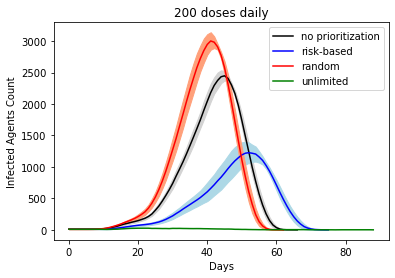

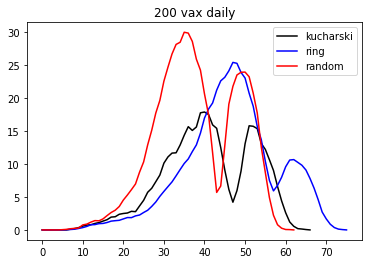

In [1820]:
def mean_inf_graph(lst_res, strat):
    total_inf = lst_res[strat]
    max_day = max(len(lst) for lst in total_inf)
    inf_arr_padded = np.array([list(lst) + [np.nan] * (max_day - len(lst)) for lst in total_inf])
    
    inf_mean = np.nanmean(inf_arr_padded, axis=0)
    inf_std = np.nanstd(inf_arr_padded, axis=0)
    inf_se = inf_std / np.sqrt(len(inf_std))
    print(strat, (inf_mean.shape), (inf_std.shape))
    return inf_mean, inf_std, inf_se

#print(inf_se_ring)
inf_mean_ring, inf_std_ring, inf_se_ring = mean_inf_graph(infected200, 'ring')
inf_mean_kuch, inf_std_kuch, inf_se_kuch = mean_inf_graph(infected200, 'kucharski')
inf_mean_rand, inf_std_rand, inf_se_rand = mean_inf_graph(infected200, 'random')

plt.plot(inf_mean_kuch, 'k', label = 'no prioritization')
y1 = inf_mean_kuch + inf_std_kuch
y2 = inf_mean_kuch - inf_std_kuch

plt.fill_between(list(range(len(y1))), y1, y2, where=(y1 >= y2), interpolate=True, color='lightgray')

y1 = inf_mean_ring + inf_std_ring
y2 = inf_mean_ring - inf_std_ring
plt.plot(inf_mean_ring, 'b', label = 'risk-based')
plt.fill_between(list(range(len(y1))), y1, y2, where=(y1 >= y2), interpolate=True, color='lightblue')


y1 = inf_mean_rand + inf_std_rand
y2 = inf_mean_rand - inf_std_rand
plt.plot(inf_mean_rand, 'r', label = 'random')
plt.fill_between(list(range(len(y1))), y1, y2, where=(y1 >= y2), interpolate=True, color='lightsalmon')



plt.plot(total_inf_mean, 'g', label = 'unlimited')
plt.title('200 doses daily')
plt.legend()
plt.ylabel('Infected Agents Count')
plt.xlabel('Days')
plt.show()

plt.plot(inf_se_kuch, 'k', label = 'kucharski')
plt.plot(inf_se_ring, 'b', label = 'ring')
plt.plot(inf_se_rand, 'r', label = 'random')
plt.title('200 vax daily')
plt.legend()
plt.show()

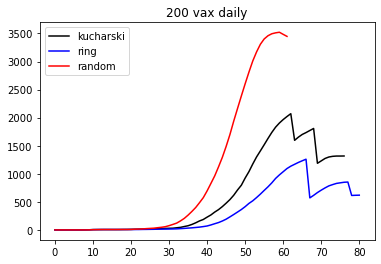

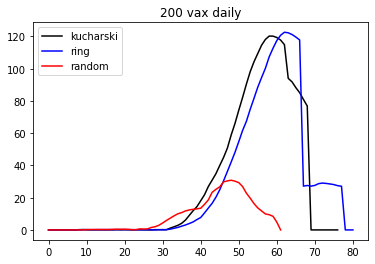

In [1310]:
dea_mean_ring, dea_std_ring, dea_se_ring = mean_inf_graph(deceased200, 'ring')
dea_mean_kuch, dea_std_kuch, dea_se_kuch = mean_inf_graph(deceased200, 'kucharski')
dea_mean_rand, dea_std_rand, dea_se_rand = mean_inf_graph(deceased200, 'random')
plt.plot(dea_mean_kuch, 'k', label = 'kucharski')
plt.plot(dea_mean_ring, 'b', label = 'ring')
plt.plot(dea_mean_rand, 'r', label = 'random')
plt.title('200 vax daily')
plt.legend()
plt.show()

plt.plot(dea_se_kuch, 'k', label = 'kucharski')
plt.plot(dea_se_ring, 'b', label = 'ring')
plt.plot(dea_se_rand, 'r', label = 'random')
plt.title('200 vax daily')
plt.legend()
plt.show()

In [1777]:
infected300

{'kucharski': [array([ 10,  10,  10,  10,  10,  10,  10,  11,  13,  15,  15,  24,  32,
          33,  47,  54,  69,  79,  85,  99, 105, 112, 122, 136, 144, 164,
         206, 238, 272, 330, 383, 425, 469, 495, 529, 572, 582, 595, 595,
         588, 589, 569, 565, 537, 494, 422, 372, 312, 253, 193, 142, 106,
          63,  33,  11,   4,   2,   0]),
  array([ 10,  10,  10,  10,  10,  10,  10,  12,  11,  12,  14,  19,  23,
          32,  42,  54,  64,  77,  90,  91,  95, 102, 117, 122, 133, 159,
         188, 210, 238, 267, 302, 341, 385, 424, 447, 472, 499, 510, 542,
         560, 559, 544, 533, 505, 471, 413, 365, 314, 241, 187, 144, 105,
          85,  48,  22,  14,   5,   1,   0]),
  array([ 10,  10,  10,  10,  10,  10,  11,  11,  13,  14,  22,  28,  36,
          45,  51,  62,  76,  85, 101, 107, 114, 127, 130, 150, 174, 194,
         213, 251, 280, 333, 386, 421, 466, 499, 555, 589, 626, 630, 653,
         669, 668, 664, 632, 575, 511, 463, 401, 339, 273, 211, 152, 101,
          59

In [1625]:
def mean_deceased(lst, strat):
    last_day_deceased = []
    for i in range(len(lst[strat])):
        last_day_deceased.append(lst[strat][i][-1])
    ci = st.t.interval(alpha=0.95, df=len(last_day_deceased)-1, loc=np.mean(last_day_deceased), 
                       scale=st.sem(last_day_deceased)) 
    return np.mean(last_day_deceased), np.std(last_day_deceased), ci

print(mean_deceased(deceased300, 'ring'))
print('200 doses')
print("""        {:<3}      {:<3}         {:<3}      {:<3}
Ring  :  {:<3}   {:<3}   {:<3}      {:<3}
70%   :  {:<3}   {:<3}     {:<3}      {:<3}
Random:  {:<3}   {:<3}   {:<3}      {:<3}\n""".format('Mean', 'Std', 'Lower I', 'Upper I',
                                  np.round(mean_deceased(deceased50, 'ring')[0], 2),
                                 np.round(mean_deceased(deceased50, 'ring')[1], 2),
                                np.round(mean_deceased(deceased50, 'ring')[2][0], 2),
                                                    np.round(mean_deceased(deceased50, 'ring')[2][1], 2),
                                 np.round(mean_deceased(deceased50, 'kucharski')[0], 2),
                                 np.round(mean_deceased(deceased50, 'kucharski')[1], 2),
                                np.round(mean_deceased(deceased50, 'kucharski')[2][0], 2),
                                                      np.round(mean_deceased(deceased50, 'kucharski')[2][1], 2),
                                np.round(mean_deceased(deceased50, 'random')[0], 2),
                                 np.round(mean_deceased(deceased50, 'random')[1], 2), 
                                np.round(mean_deceased(deceased50, 'random')[2][0], 2), 
                                                     np.round(mean_deceased(deceased50, 'random')[2][1], 2)))



(433.0, 74.89611853379701, (358.18270370031263, 507.81729629968737))
200 doses
        Mean      Std         Lower I      Upper I
Ring  :  9687.4   67.46   9593.76      9781.04
70%   :  9922.8   63.55     9834.58      10011.02
Random:  10038.4   66.7   9945.81      10130.99



# SAR

In [1967]:
hh_sar = 0.123
non_hh_sar = 0.048
hh_multiplier = hh_sar / non_hh_sar
pr_base = hh_sar / (np.sum(fraction * exposure_multiplier))
print(pr_base)
def sar(T, prob_infected = pr_base, prob_highly_trans = 0.05, 
                                highly_inf_mult = 100, hh_mult = hh_multiplier, num_vaccines = 300, 
                               vax_waiting_time = 9, m = 1, display = False):
    N = len(age_bin)
    infected_agents = np.random.choice(age_bin['age'].index, size = 10, replace=False)
    agent_status = np.zeros(N)
    agent_incubation = np.zeros(N)
    agent_infection_period = np.zeros(N)
    agent_vaccine_waiting_time = np.zeros(N)
    agent_risk_score = np.zeros(N)
    #agent_time = np.zeros(N)
    #prob_infected = 0.0024
    #prob_highly_trans = 0.05
    #highly_inf_mult = 100
    
    """
    status:
    0: susceptible
    1: incubated
    2: infected
    3: vaccinated - waiting time
    
    4: immune or (recovvered)
    5: deceased (not implemented yet)
    
    6: highly transmissive
    """

    for index_case in infected_agents:
        if (bernoulli.rvs(prob_highly_trans * m) == 1):
            #print(True)
            agent_status[index_case] = 6
        else:
            agent_status[index_case] = 2
        # sample infected period, start infection right away
        agent_infection_period[index_case] = int(lognorm.rvs(scale = np.exp(2.2915072), s = 0.1331699))

    infected = np.array([len(infected_agents)])
    susceptible = np.array([N - infected[0]])
    removed = np.array([0])
    dead = np.array([0])
    vaccinated = np.array([0])
    total_vax = 0

    print((np.sum(agent_status == 6)))
    
    HH_SAR = []
    NONHH_SAR = []
    SAR = []
    
    for t in range(T):
        sar_num, sar_den = [], []
        sar_hh_num, sar_hh_den = [], []
        sar_nonhh_num, sar_nonhh_den = [], []
        
        edge_dict_by_node = sample_connections()
        #print(len(edge_dict_by_node))
        weight_matrix = sample_edge_weights(edge_dict_by_node)
        #print(weight_matrix.shape)
                    
        
        infected_cases = np.where((agent_status == 2) | (agent_status == 6))[0]
        
        """for all infected agents
            for all their contacts
                risk = base prob
                if hh
                    risk *= hh multiplier
                for all contacts of contact
                    risk = base prb^2
                    if contact is infected
                        contacts of contact have the same infection chance
                        risk = base prob
                    if contacts are household of contact
                        risk
        """
        
        """
        for index_case in infected_cases:
            first_hop = edge_dict_by_node[index_case]
            
            for contact in first_hop:
                temp_risk_score = prob_infected * weight_matrix[index_case][contact]
                if contact in hh_connections_dict[index_case]:
                    temp_risk_score *= hh_mult 
                agent_risk_score[contact] = max(agent_risk_score[contact], temp_risk_score)
                # get contacts of contact - 2nd hop
                second_hop = edge_dict_by_node[contact]
                
                for second_c in second_hop:
                    agent_risk_score[second_c] = prob_infected * weight_matrix[index_case][second_c]
                    if agent_status[contact] == 2 or agent_status[contact] == 6:
                        agent_risk_score[second_c] = prob_infected * weight_matrix[contact][second_c]
                    if second_c in hh_connections_dict[contact] and second_c not in hh_connections_dict[index_case]:
                        agent_risk_score[second_c] *= hh_mult
        
        top_n_vaccinees = []
        sorted_risk_values = np.argsort(agent_risk_score)
        top_n_vaccinees = sorted_risk_values[::-1]
    
        count_vaccines = 0
        for vaccinee in top_n_vaccinees:
            
            #if agent is infected(2)/highly inf (6), already vaxed (3), immune (4), or deceased (5) => skip
            
            if ((agent_status[vaccinee] == 2) or (agent_status[vaccinee] == 6) or
               (agent_status[vaccinee] == 3) or (agent_status[vaccinee] == 4) or (agent_status[vaccinee] == 5)):
                continue
            else:
                if (bernoulli.rvs(0.7) == 1):
                    agent_status[vaccinee] = 3
                    agent_vaccine_waiting_time[vaccinee] = vax_waiting_time
                    count_vaccines += 1
                    total_vax += 1
            if count_vaccines == num_vaccines:
                break


        if count_vaccines < num_vaccines:
            remaining_vaccines = num_vaccines - count_vaccines
            sus_agents = np.where((agent_status == 0) | (agent_status == 1))[0]
            group_size = min([remaining_vaccines, len(sus_agents)])
            random_sus_vaccinees = np.random.choice(sus_agents, size = group_size, replace = False)
            for r in random_sus_vaccinees:
                agent_status[r] = 3
                agent_vaccine_waiting_time[r] = vax_waiting_time
                total_vax += 1
                    
                
            #print(agent_risk_score[vax])
        
        """
        
        for i in range(len(agent_status)):
            
            infected_hh = 0
            infected_nonhh = 0
            infected_total = 0
            
            # if agent is inf or highly inf and during inf period
            if ((agent_status[i] == 2 or agent_status[i] == 6) and agent_infection_period[i] > 0):

                contacts = edge_dict_by_node[i]
                contacts_of_contact = {}
                for j in contacts:
                    contacts_of_j = edge_dict_by_node[j]
                    contacts_of_contact[j] = []
                    for k in contacts_of_j:
                        contacts_of_contact[j].append(k)

                #ring = np.unique(np.concatenate((contacts, contacts_of_contact)))
                ########################
                
                temp_prob_infected = prob_infected

                
                for contact in contacts:
                    if agent_status[contact] == 0: # infecting susceptible
                        prob = temp_prob_infected * weight_matrix[i][contact]
                        is_hh = False
                        if contact in hh_connections_dict[i]:
                            prob *= hh_mult
                            is_hh = True
                        if (prob > 1):
                            prob = 1
                        #print(prob)
                        if (bernoulli.rvs(prob) == 1): # if contact is infected, start incubation
                            agent_status[contact] = 1
                            agent_incubation[contact] = int(lognorm.rvs(scale = np.exp(2.446), s = 0.2841191))
                            if is_hh == True:
                                infected_hh += 1
                            else:
                                infected_nonhh += 1
                            
                    
                    
                    
                    for sub_contact in contacts_of_contact[contact]:
                        # contacts of an infected contact
                        # P(contact of contact infected) = P(contact infected) * P(contact of contact infected | contact infected)
                        sub_prob = (temp_prob_infected**2) * weight_matrix[i][sub_contact] * weight_matrix[contact][sub_contact]
                        if agent_status[sub_contact] == 0:
                            # if contact is infected,  
                            if agent_status[contact] == 2 or agent_status[contact] == 6:
                                sub_prob = weight_matrix[contact][sub_contact] * temp_prob_infected
                                # if c of c is household of c
                                if ((sub_contact in hh_connections_dict[contact]) and
                                (sub_contact not in hh_connections_dict[i])):
                                    sub_prob *= hh_mult
                            else:
                                
                                sub_prob = (temp_prob_infected**2) * weight_matrix[i][contact] * weight_matrix[contact][sub_contact]

                            if sub_prob > 1:
                                sub_prob = 1
                            #print(sub_prob, '\n')
                            if (bernoulli.rvs(sub_prob) == 1): # if contact is infected, start incubation
                                agent_status[sub_contact] = 1
                                agent_incubation[sub_contact] = int(lognorm.rvs(scale = np.exp(2.446), s = 0.2841191))
                                infected_nonhh += 1
                    
                
                num_hh = len(hh_connections_dict[i])
                num_nonhh = len(contacts) - num_hh + len(contacts_of_contact)
                num_total = len(contacts) + len(contacts_of_contact)
                
                sar_num.append((infected_nonhh + infected_hh))
                sar_hh_num.append(infected_hh)
                sar_nonhh_num.append(infected_nonhh)
                
                sar_den.append(num_total)
                sar_hh_den.append(num_hh)
                sar_nonhh_den.append(num_nonhh)
                
                agent_infection_period[i] -= 1

            # if agent is inf and done with inf period -> remove
            elif ((agent_status[i] == 2 or agent_status[i] == 6) and (agent_infection_period[i] == 0)):
                cfr = age_cfr[i]
                if ((bernoulli.rvs(cfr) == 1)):
                    agent_status[i] = 5
                else:
                    agent_status[i] = 4
            # if agent is incubating
            elif (agent_status[i] == 1):
                # done incubating, start infection
                if agent_incubation[i] == 0:
                    if (bernoulli.rvs(prob_highly_trans) == 1):
                        agent_status[i] = 6
                    else:
                        agent_status[i] = 2

                    agent_infection_period[i] = int(lognorm.rvs(scale = np.exp(2.2915072), s = 0.1331699))
                else: # still incubating
                    agent_incubation[i] -= 1

            # if agent is vaccinated
            elif (agent_status[i] == 3):
                if agent_vaccine_waiting_time[i] == 0: # built up immunity -> removed
                    agent_status[i] = 4
                else: # still building immunity
                    agent_vaccine_waiting_time[i] -= 1    

            # agent is susceptible
            elif ((agent_status[i] == 0) or (agent_status[i] == 4) or agent_status[i] == 5):
                continue


        if display == True:
            print('incubate: ', np.sum(agent_status == 1))
            print('hh: ', np.sum(sar_hh_num) / np.sum(sar_hh_den))
            print('non-hh: ', np.sum(sar_nonhh_num) / np.sum(sar_nonhh_den))
        #print('high', np.sum(agent_status == 6))
        infected = np.append(infected, np.sum(agent_status == 2) + np.sum(agent_status == 6))
        susceptible = np.append(susceptible, np.sum(agent_status == 0))
        vaccinated = np.append(vaccinated, np.sum(agent_status == 3))
        removed = np.append(removed, np.sum(agent_status == 4))
        dead = np.append(dead, np.sum(agent_status == 5))
        
        HH_SAR.append(np.sum(sar_hh_num) / np.sum(sar_hh_den))
        NONHH_SAR.append(np.sum(sar_nonhh_num) / np.sum(sar_nonhh_den))
        SAR.append(np.sum(sar_num) / np.sum(sar_den))
        
        if (np.sum(agent_status == 2) + np.sum(agent_status == 6)) == 0 and (np.sum(agent_status == 1) == 0):
            break
    return SAR, HH_SAR, NONHH_SAR


0.019619729893515715


0


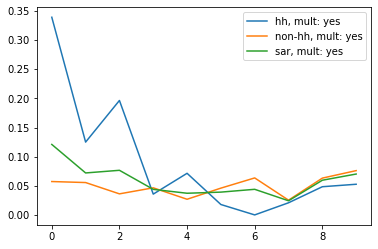

[0.3392857142857143,
 0.125,
 0.19642857142857142,
 0.03571428571428571,
 0.07142857142857142,
 0.017857142857142856,
 0.0,
 0.020833333333333332,
 0.04838709677419355,
 0.05263157894736842]

[0.057291666666666664,
 0.05555555555555555,
 0.03614457831325301,
 0.046511627906976744,
 0.026881720430107527,
 0.04597701149425287,
 0.06349206349206349,
 0.02531645569620253,
 0.06315789473684211,
 0.07602339181286549]

[0.12096774193548387,
 0.07203389830508475,
 0.07657657657657657,
 0.043859649122807015,
 0.0371900826446281,
 0.0391304347826087,
 0.04395604395604396,
 0.024271844660194174,
 0.05952380952380952,
 0.07017543859649122]

0


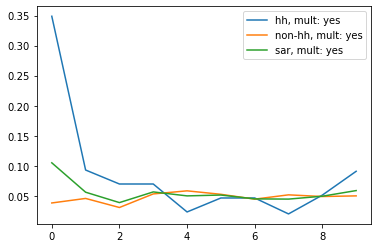

[0.3488372093023256,
 0.09302325581395349,
 0.06976744186046512,
 0.06976744186046512,
 0.023255813953488372,
 0.046511627906976744,
 0.046511627906976744,
 0.02,
 0.05128205128205128,
 0.09090909090909091]

[0.03821656050955414,
 0.0457516339869281,
 0.03067484662576687,
 0.05325443786982249,
 0.058394160583941604,
 0.05263157894736842,
 0.044585987261146494,
 0.05172413793103448,
 0.04895104895104895,
 0.05]

[0.105,
 0.05612244897959184,
 0.038834951456310676,
 0.05660377358490566,
 0.05,
 0.0514018691588785,
 0.045,
 0.044642857142857144,
 0.04945054945054945,
 0.058823529411764705]

0


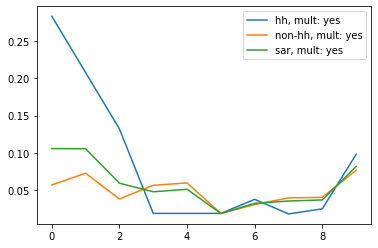

[0.2830188679245283,
 0.20754716981132076,
 0.1320754716981132,
 0.018867924528301886,
 0.018867924528301886,
 0.018867924528301886,
 0.03773584905660377,
 0.01818181818181818,
 0.025,
 0.09803921568627451]

[0.05699481865284974,
 0.07272727272727272,
 0.03825136612021858,
 0.05649717514124294,
 0.05970149253731343,
 0.018779342723004695,
 0.03076923076923077,
 0.039647577092511016,
 0.04044117647058824,
 0.07668711656441718]

[0.10569105691056911,
 0.10550458715596331,
 0.059322033898305086,
 0.04782608695652174,
 0.051181102362204724,
 0.018796992481203006,
 0.03225806451612903,
 0.03546099290780142,
 0.036931818181818184,
 0.08177570093457943]

In [1977]:
for i in range(3):
    total, hh, nonhh = sar(T = 10, prob_highly_trans = 0, m = 0, display = False)
    plt.plot(hh, label = 'hh, mult: yes')
    plt.plot(nonhh, label = 'non-hh, mult: yes')
    plt.plot(total, label = 'sar, mult: yes')
    plt.legend()
    plt.show()
    display(hh)
    display(nonhh)
    display(total)

0


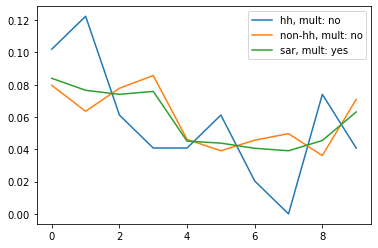

[0.10204081632653061,
 0.12244897959183673,
 0.061224489795918366,
 0.04081632653061224,
 0.04081632653061224,
 0.061224489795918366,
 0.02040816326530612,
 0.0,
 0.07407407407407407,
 0.04081632653061224]

[0.07960199004975124,
 0.06358381502890173,
 0.07784431137724551,
 0.08571428571428572,
 0.046153846153846156,
 0.03910614525139665,
 0.04568527918781726,
 0.049723756906077346,
 0.03614457831325301,
 0.07092198581560284]

[0.084,
 0.07657657657657657,
 0.07407407407407407,
 0.07589285714285714,
 0.045081967213114756,
 0.043859649122807015,
 0.04065040650406504,
 0.0391304347826087,
 0.045454545454545456,
 0.06315789473684211]

0


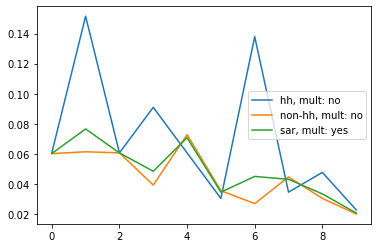

[0.06060606060606061,
 0.15151515151515152,
 0.06060606060606061,
 0.09090909090909091,
 0.06060606060606061,
 0.030303030303030304,
 0.13793103448275862,
 0.034482758620689655,
 0.047619047619047616,
 0.022727272727272728]

[0.060109289617486336,
 0.06134969325153374,
 0.06060606060606061,
 0.0392156862745098,
 0.07272727272727272,
 0.03546099290780142,
 0.026845637583892617,
 0.044585987261146494,
 0.030303030303030304,
 0.02]

[0.06018518518518518,
 0.07653061224489796,
 0.06060606060606061,
 0.04838709677419355,
 0.0707070707070707,
 0.034482758620689655,
 0.0449438202247191,
 0.043010752688172046,
 0.03333333333333333,
 0.020618556701030927]

0


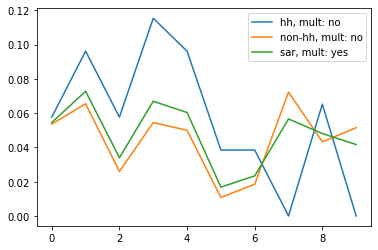

[0.057692307692307696,
 0.09615384615384616,
 0.057692307692307696,
 0.11538461538461539,
 0.09615384615384616,
 0.038461538461538464,
 0.038461538461538464,
 0.0,
 0.06521739130434782,
 0.0]

[0.05357142857142857,
 0.06547619047619048,
 0.025974025974025976,
 0.054455445544554455,
 0.05,
 0.010752688172043012,
 0.018518518518518517,
 0.07228915662650602,
 0.043209876543209874,
 0.05154639175257732]

[0.05454545454545454,
 0.07272727272727272,
 0.03398058252427184,
 0.06692913385826772,
 0.0603448275862069,
 0.01680672268907563,
 0.02336448598130841,
 0.05660377358490566,
 0.04807692307692308,
 0.041666666666666664]

In [1976]:
for i in range(3):
    total, hh, nonhh = sar(T = 10, prob_highly_trans = 0, hh_mult = 1, m = 0, display = False)
    plt.plot(hh, label = 'hh, mult: no')
    plt.plot(nonhh, label = 'non-hh, mult: no')
    plt.plot(total, label = 'sar, mult: yes')
    plt.legend()
    plt.show()
    display(hh)
    display(nonhh)
    display(total)

# R and k optimize

In [535]:
def get_rk():
    N = 14652
    infected_agents = np.random.choice(age_bin['age'].index, size = 152, replace=False)
    agent_status = np.zeros(N)
    agent_incubation = np.zeros(N)
    agent_infection_period = np.zeros(N)
    #agent_time = np.zeros(N)
    prob_infected = 0.005#0.001
    prob_highly_transmissive = 0.05
    highly_inf_mult = 100#150
    """
    status:
    0: susceptible
    1: incubated
    2: infected
    5: highly infectious
    
    3: vaccinated
    4: removed (death/recovvered)
    """
        
    for index_case in infected_agents:
        if (bernoulli.rvs(prob_highly_transmissive) == 1):
            agent_status[index_case] = 5
            #print(True)
        else:
            agent_status[index_case] = 2
        # sample infected period, start infection right away
        agent_infection_period[index_case] = int(lognorm.rvs(scale = np.exp(2.2915072), s = 0.1331699))
    
    max_infection_period = int(max(agent_infection_period))
    
    #vaccinated = np.array([0])
    agent_second = np.zeros(N)
    edge_dict_by_node = sample_connections()
    num_contacts_per_agent = np.zeros(N)
    
    
    for t in range(max_infection_period):
        #print(np.sum(agent_status == 1))
        for i in infected_agents:
            num_contacts_per_agent[i] = len(edge_dict_by_node[i])
            if agent_infection_period[i] > 0:
                temp_prob_infected = prob_infected
                if agent_status[i] == 5:
                    temp_prob_infected *= highly_inf_mult
                    #q += 1
                    #print(q)
                #print(temp_prob_infected)
                count_second_case = 0
                
                contacts = edge_dict_by_node[i]
                contacts_of_contact = []
                for j in contacts:
                    contacts_of_j = edge_dict_by_node[j]
                    for k in contacts_of_j:
                        contacts_of_contact.append(k)
                
                ring = np.unique(np.concatenate((contacts, contacts_of_contact)))
                
                for contact in ring:
                    if agent_status[contact] == 0: #if contact is susceptible
                        if (bernoulli.rvs(temp_prob_infected) == 1):
                            agent_status[contact] = 1 # change sus -> incubated
                            count_second_case += 1
                            #agent_incubation[contact] = int(lognorm.rvs(scale = np.exp(2.446), s = 0.2841191))
                    else:
                        continue
                agent_second[i] += count_second_case
                agent_infection_period[i] -= 1
    
    incubated = np.sum(agent_status == 1)
    return incubated, agent_status, agent_second, num_contacts_per_agent
        

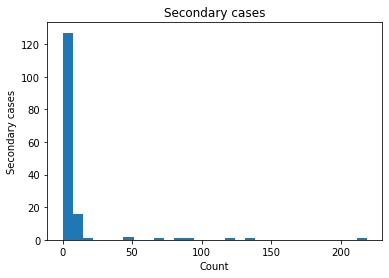

{1: 15,
 132: 1,
 3: 27,
 6: 15,
 5: 19,
 2: 20,
 7: 11,
 4: 16,
 10: 4,
 0: 4,
 48: 1,
 15: 1,
 91: 1,
 67: 1,
 8: 7,
 12: 1,
 117: 1,
 9: 2,
 11: 1,
 47: 1,
 219: 1,
 13: 1,
 81: 1}

In [538]:
temp_total_second_cases = []
temp_new_incubate = []
temp_total_contacts_second = []
for t in range(1):
    total = 0
    total_num, agent_status, ls_secondary_cases, ls_count_contact = get_rk()
    for i in range(len(agent_status)):
        if agent_status[i] == 2 or agent_status[i] == 5:
            total += ls_secondary_cases[i]
            temp_new_incubate.append(ls_secondary_cases[i])
            temp_total_contacts_second.append(ls_count_contact[i])
    temp_total_second_cases.append(total)
#temp_new_incubate, temp_total_second_cases
temp_unique_count = {}
for i in temp_new_incubate:
    i = int(i)
    if i not in temp_unique_count:
        temp_unique_count[i] = 1
    else:
        temp_unique_count[i] += 1

plt.hist(temp_new_incubate, bins = 30)
plt.title('Secondary cases')
plt.xlabel('Count')
plt.ylabel('Secondary cases')
plt.show()
temp_unique_count

# optimizer

In [ ]:
import statsmodels.formula.api as smf
from scipy.stats import nbinom

In [539]:
# Analysis models


def convert_params(mu, alpha):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    Parameters
    ----------
    mu : float
       Mean of NB distribution.
    alpha : float
       Overdispersion parameter used for variance calculation.

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    var = mu + alpha * mu ** 2
    p = mu / var
    r = mu ** 2 / (var - mu)
    return r, p


sample = temp_new_incubate
#n = 5
#p = 0.1
#sample = nbinom.rvs(n=n, p=p, size=10000)

# Estimate parameters
## Mean estimates expectation parameter for negative binomial distribution
mu = np.mean(sample) 
print(mu)

## Dispersion parameter from nb model with only interaction term
nbfit = smf.negativebinomial("nbdata ~ 1", data=pd.DataFrame({"nbdata": temp_new_incubate})).fit()

alpha = nbfit.params[1]  # Dispersion parameter
print(alpha)

# Convert parameters to n, p parameterization
n_est, p_est = convert_params(mu, alpha)


# Check that estimates are close to the true values:
print("""
                   {:<3}   {:<3}   {:<3}
Estimates      :  {:<3}   {:<3}   {:<3}""".format('n', 'p', 'alpha',
                                  np.round(n_est, 2), np.round(p_est, 2), np.round(alpha, 2)))


9.401315789473685
Optimization terminated successfully.
         Current function value: 3.260755
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
1.388246681146303

                   n     p     alpha
Estimates      :  0.72   0.07   1.39


{2: 20, 0: 226, 3: 3, 1: 32, 12: 2, 20: 1, 4: 6, 5: 1, 7: 3, 8: 5, 6: 1}


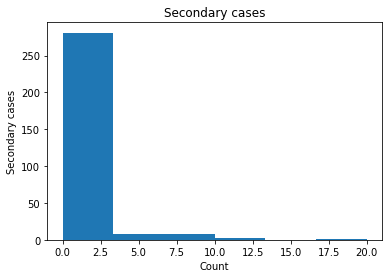

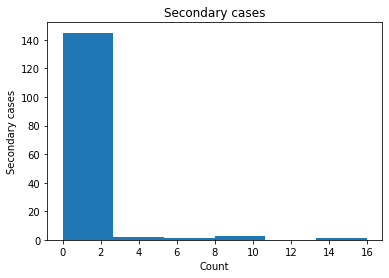

{0: 378, 2: 163, 1: 353, 3: 69, 4: 26, 5: 9, 6: 2}


In [456]:
n = 0.18
p = 0.16
sample = nbinom.rvs(n=n, p=p, size=300)
unique_count = {}
for i in sample:
    if i not in unique_count:
        unique_count[i] = 1
    else:
        unique_count[i] += 1
print(unique_count)
plt.hist(sample, bins = 6)
plt.title('Secondary cases')
plt.xlabel('Count')
plt.ylabel('Secondary cases')
plt.show()
unique_count = {}
for i in new_incubate:
    i = int(i)
    if i not in unique_count:
        unique_count[i] = 1
    else:
        unique_count[i] += 1
plt.hist(temp_new_incubate, bins = 6)
plt.title('Secondary cases')
plt.xlabel('Count')
plt.ylabel('Secondary cases')
plt.show()
print(unique_count)

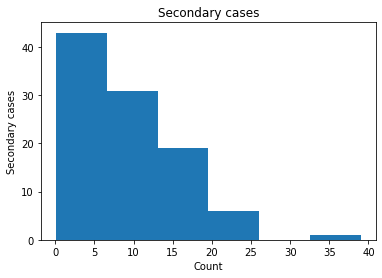

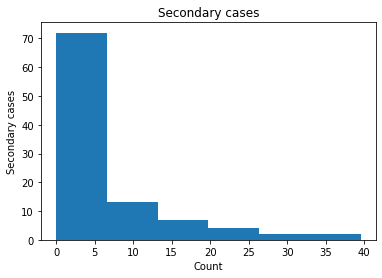

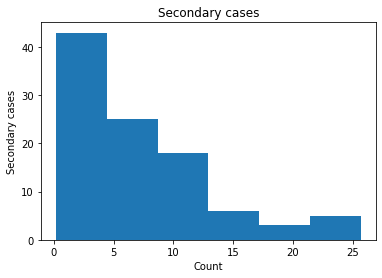

In [509]:
mean = 9.1
std = 7.3
shape = (mean / std) ** 2
scale = (std ** 2) / mean
samples = gamma.rvs(a=shape, scale=scale, size = 100)
#print(samples)
plt.hist(samples, bins = 6)
plt.title('Secondary cases')
plt.xlabel('Count')
plt.ylabel('Secondary cases')
plt.show()

mean = 7.5
std = 10.4
shape = (mean / std) ** 2
scale = (std ** 2) / mean
samples = gamma.rvs(a=shape, scale=scale, size = 100)
#print(samples + 9)
plt.hist(samples, bins = 6)
plt.title('Secondary cases')
plt.xlabel('Count')
plt.ylabel('Secondary cases')
plt.show()

mean = 6.4
std = 5.3
shape = (mean / std) ** 2
scale = (std ** 2) / mean
samples = gamma.rvs(a=shape, scale=scale, size = 100)
#print(samples)
plt.hist(samples, bins = 6)
plt.title('Secondary cases')
plt.xlabel('Count')
plt.ylabel('Secondary cases')
plt.show()

In [4]:
import numpy as np
numerator = np.array([120, 297, 125, 19, 74, 102])
denominator = np.array([120, 297, 125, 19, 74, 102])
exposure_multiplier = np.array([9.7, 8.3, 5.6, 4.9, 1.3, 1])

fraction = numerator / np.sum(denominator)

# handle fluid, direct wet, 
#nonHH_numerator = np.array([120 - 50, 297 - 200, 125, 19 + 15, 74 + 35, 102 + 200])
nonHH_denominator = np.array([120 - 70, 297 - 240, 125 + 10, 19 + 75, 74 + 185, 102 + 160])
#nonHH_fraction = nonHH_denominator / np.sum(nonHH_denominator)
#print(np.random.uniform())

hh_sar = 0.123
non_hh_sar = 0.048
pr_base = hh_sar / (np.sum(fraction * exposure_multiplier))
hh_connections_dict = np.load('data/hh_connections.npy',allow_pickle='TRUE').item()

def sample_edge_weights(num_edges = 14652):
    exposure = np.zeros((num_edges, num_edges))
    for i in range(num_edges):
        for j in range(num_edges):
            #temp_pr = np.random.uniform()
            #print(temp_pr, weight_assignment(temp_pr))
            if j in hh_connections_dict[i]:
                exposure[i][j] = np.random.choice(exposure_multiplier, p=fraction)
            else:
                exposure[i][j] = non_hh_sar / pr_base

    return exposure

sample_edge_weights()

array([[2.44651686, 2.44651686, 2.44651686, ..., 2.44651686, 2.44651686,
        2.44651686],
       [2.44651686, 2.44651686, 2.44651686, ..., 2.44651686, 2.44651686,
        2.44651686],
       [2.44651686, 2.44651686, 2.44651686, ..., 2.44651686, 2.44651686,
        2.44651686],
       ...,
       [2.44651686, 2.44651686, 2.44651686, ..., 2.44651686, 2.44651686,
        8.3       ],
       [2.44651686, 2.44651686, 2.44651686, ..., 2.44651686, 2.44651686,
        2.44651686],
       [2.44651686, 2.44651686, 2.44651686, ..., 9.7       , 2.44651686,
        2.44651686]])

In [5]:
hh_connections_dict[0]

[3432, 6545, 9118]

In [8]:
%%time
testy = sample_edge_weights()

CPU times: user 48.6 s, sys: 453 ms, total: 49.1 s
Wall time: 49.5 s


In [13]:
testy[0][1]

2.4465168613694277